In [1]:
# tiny shakespear

from neurotron import Cells, Train, Token, Monitor, Ansi, SynapseErr
import neurotron.math as nm
isa = isinstance

In [2]:
class Trainer(Train):
    def __init__(self,cells,plot=False):
        super().__init__(cells)
        self.plotting = plot

    def prediction(self,context):
        if context in self._contexts:
            info = self._contexts[context]
            counters = []; total = 0
            for key in info:
                if not key in ['#','@']:
                    n,refer,idx = info[key]
                    total += n
                    counters.append(n)
                    #print('    statistics: %s:' % key,(counters,total))
            result = []; k = 0
            src = self.address(context)
            for key in info:
                if not key in ['#','@']:
                    ratio = counters[k]/total
                    k += 1
                    n,refer,idx = info[key]
                    dst = self.address(refer)
                    result.append((refer,ratio,src,dst))
                    #print('    predict(%g%%): %s ->'%(100*ratio,key),info[key])
            return result

    def predict(self,context):
        results = self.prediction(context)
        for prediction in results:
            refer,ratio,src,dst = prediction
            print('    %g%%: ->' % (100*ratio),refer,src,dst)
    
    def address(self,context):
        if context in self._contexts:
            info = self._contexts[context]
            #print('##### info:',info)
            m,n,d,s = self.cells.shape
            idx = train.code((info['@'][1])).list()[0]; 
            jdx = info['#'][0]
            assert len(idx) == len(jdx)
            kdx = [jdx[s]*m+idx[s] for s in range(len(idx))]
            #return ((m,n),idx,jdx,kdx)
            return kdx
        return None

    def learn(self,context):
        results = self.prediction(context)
        for prediction in results:
            refer,ratio,src,dst = prediction
            print('    %g%%: ->' % (100*ratio),refer,src,dst)
            self.cells.init()
            for k in dst:
                self.cells.X[k] = 1
            for k in src:
                self.cells.Y[k] = 1

            self.cells.connect(src,dst)
            title = 'learn: ' + refer
            if self.plotting: self.plot(title)
            self.cells.init()

    def program(self,verbose=0):   # learn all contexts
        """
        learn all contexts
        >>> train = Trainer(Cells('Mary'))
        >>> train.program()
        """
        for context in self._contexts:
            results = self.prediction(context)
            for prediction in results:
                refer,ratio,src,dst = prediction
                #print('    %g%%: ->' % (100*ratio),refer,src,dst)
                for k in dst:
                    self.cells.X[k] = 1
                for k in src:
                    self.cells.Y[k] = 1
                try:
                    self.cells.connect(src,dst)
                    if verbose:
                        print(Ansi.G + '    learning:',context,'OK'+Ansi.N)
                except SynapseErr:
                    print(Ansi.R+'    learning:',context,'FAIL'+Ansi.N)

    def plot(self,title=''):
        m,n,d,s = self.cells.shape
        mon = Monitor(m,n)
        self.cells.plot(mon,label=True)
        mon.title(title)

    def analyse(self,sentence,all=False):
        if all:
            prediction = self.cells.process(sentence)
        else:
            prediction = self.cells.run(sentence)
            self.plot()
        return prediction
        

In [3]:
text = \
"""
First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.
"""
def chunkify(text,m,n): 
    k = 1; chunks = []
    for i in range(m): 
        row = [] 
        for j in range(n):
            row.append(text[k]); k += 1
        chunks.append(row);
    return chunks

chunks = chunkify(text,10,8) 
chunks

[['F', 'i', 'r', 's', 't', ' ', 'C', 'i'],
 ['t', 'i', 'z', 'e', 'n', ':', '\n', 'W'],
 ['e', ' ', 'a', 'r', 'e', ' ', 'a', 'c'],
 ['c', 'o', 'u', 'n', 't', 'e', 'd', ' '],
 ['p', 'o', 'o', 'r', ' ', 'c', 'i', 't'],
 ['i', 'z', 'e', 'n', 's', ',', ' ', 't'],
 ['h', 'e', ' ', 'p', 'a', 't', 'r', 'i'],
 ['c', 'i', 'a', 'n', 's', ' ', 'g', 'o'],
 ['o', 'd', '.', '\n', 'W', 'h', 'a', 't'],
 [' ', 'a', 'u', 't', 'h', 'o', 'r', 'i']]

token:
    [17, 18, 19] .: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
    [5, 11, 12] F: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
    [8, 9, 11] i: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
    [0, 5, 15] r: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
    [1, 12, 16] s: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
    [6, 7, 13] t: [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    [5, 11, 18]  : [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
    [10, 14, 18] C: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]
    [4, 9, 17] z: [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
    [0, 9, 13] e: [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    [1, 7, 9] n: [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    [0, 8, 17] :: [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
    [13, 15, 19] 
: [0, 0, 0, 0, 0, 0, 

['t', '->', '', '', '', '', '', '', '', '']

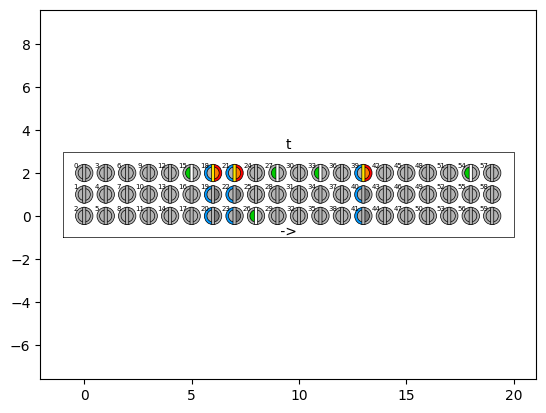

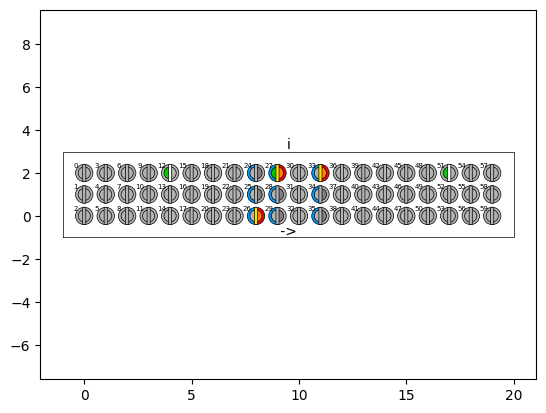

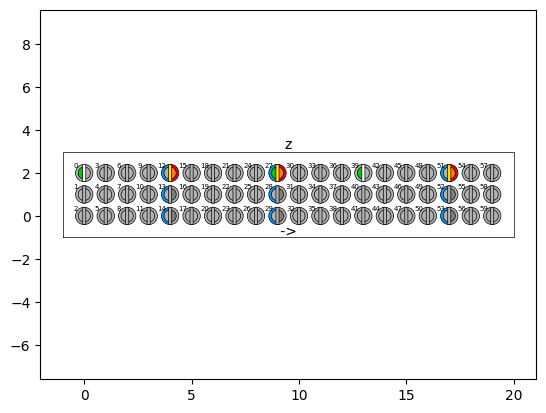

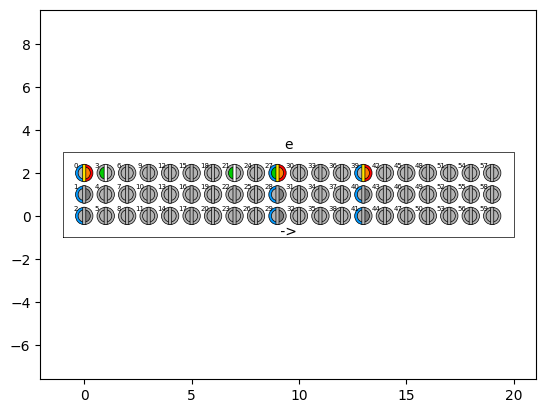

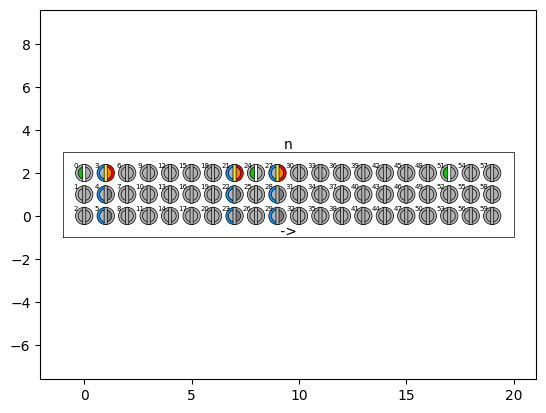

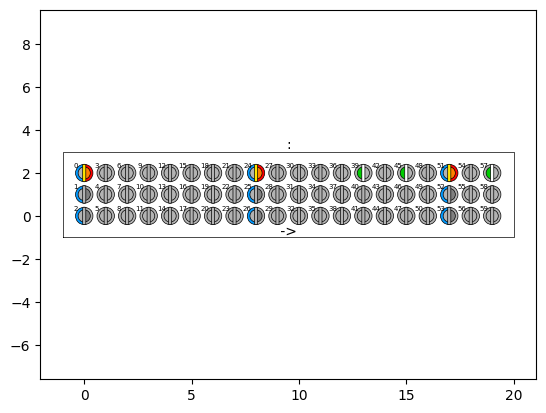

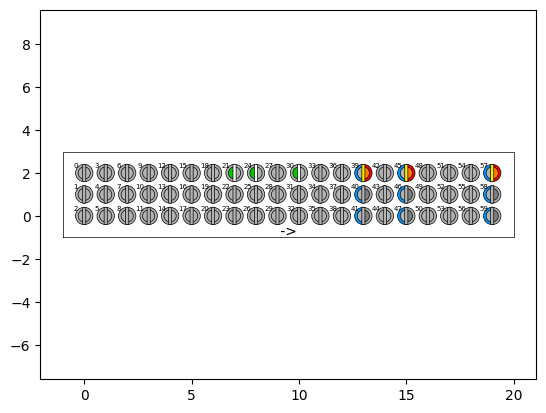

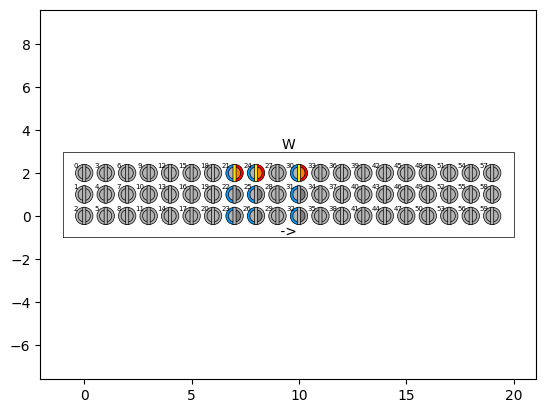

In [7]:
cells = Cells((3,20,10,3),3,verbose=0)
train = Trainer(cells,plot=True)

k = 0
for chunk in chunks:
    train(chunk); k += 1
    if k >= 2: break

train.program()
train.show()
train.analyse(chunk,all=True)
#train.predict('<Lisa likes to>')
#train.program()

#train.analyse('Lisa likes to paint',all=True)

['i', '->', '']

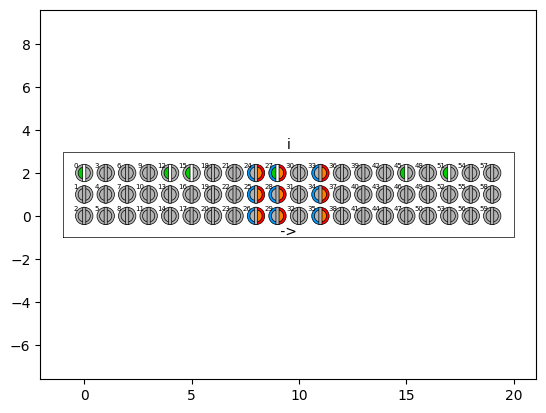

In [8]:
train.analyse('i',all=True)

In [9]:
train.predict('<t i z>')

    100%: -> <t i z e> [12, 27, 51] [0, 27, 39]


In [7]:
cells.token



{'.': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
 'F': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'i': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'r': [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 's': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
 't': [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 ' ': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
 'C': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1],
 'z': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
 'e': [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 'n': [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 ':': [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 '\n': [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 'W': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0]}